# Text Clustering
```
Author: Ignasius Harvey
Dataset: https://www.kaggle.com/dodyagung/accident
Reference: Saputro, D. A., & Girsang, A. S. (2020). Classification of Traffic Accident Information Using Machine Learning from Social Media. International Journal of Emerging Trends in Engineering Research, 8(3), 630–637. https://doi.org/10.30534/ijeter/2020/04832020
```

## Load dependencies

In [1]:
import pandas as pd
import numpy as np

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import fasttext

from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

## Load and preprocess dataset
You may download the data from Kaggle first then upload it here.

In [2]:
data = pd.read_csv('twitter_label_manual.csv')

In [3]:
def text_preprocess(series, stemmer, stopwords):
    df = series.str.replace("\n\t",  " ")
    df = df.str.replace(r"[^a-zA-Z ]+", "")
    df = df.str.lower()
    df = df.apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split() if item not in stopwords]))
    
    return df

In [4]:
stopwords = StopWordRemoverFactory().get_stop_words()
stemmer = StemmerFactory().create_stemmer()

In [5]:
data['processed_text'] = text_preprocess(data['full_text'], stemmer, stopwords)

## Use our corpus to train word embedding model
Here, we'll use the the default parameters which are 100 dimensions output and skipgram model.
I have prepared the txt in advance for simplicity, you can pre-process yourself using the full data.

In [6]:
model = fasttext.train_unsupervised('twitter.txt', model='skipgram', dim=100)

In [7]:
data['vec'] = data['processed_text'].apply(lambda x: model.get_sentence_vector(x))

## Clustering Attempt
Use Elbow Method to find the optimal number of k.
Here, we'll use K-means algorithm for clustering. You may experiment with other algorithms.

### Elbow Method

In [8]:
sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pd.DataFrame(data['vec'].values.tolist()))
    sum_of_squared_distances.append(km.inertia_)

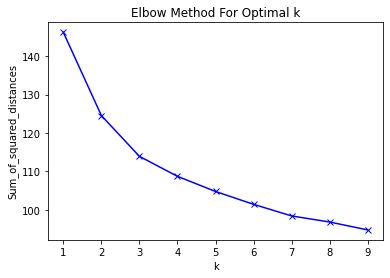

In [9]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### KMeans Clustering

In [10]:
kmeans = KMeans(n_clusters=3)  
kmeans.fit(data['vec'].values.tolist())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [11]:
data['cluster'] = kmeans.fit_predict(data['vec'].values.tolist())

In [12]:
data.groupby(['cluster'])['is_accident'].value_counts()

cluster  is_accident
0        0              398
         1               10
1        1              257
         0              243
2        1               93
         0                1
Name: is_accident, dtype: int64

### Dimension Reduction
If you want to visualize it, we can't really visualize 100 dimensions. So we use dimension reduction technique to try and visualize it.

In [13]:
pca = PCA(n_components=3)
data['x'] = pca.fit_transform(data['vec'].values.tolist())[:,0]
data['y'] = pca.fit_transform(data['vec'].values.tolist())[:,1]
data['z'] = pca.fit_transform(data['vec'].values.tolist())[:,2]

In [14]:
print(pca.explained_variance_ratio_)

[0.19469711 0.0926013  0.05161339]


#### 2D Scatterplot

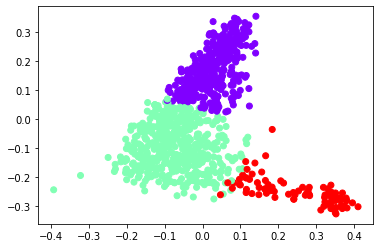

In [15]:
plt.scatter(data['y'],data['x'], c=data['cluster'], cmap='rainbow')

#### 3D Scatterplot

Text(0.5, 0.92, 'Tweet Clustering using K Means')

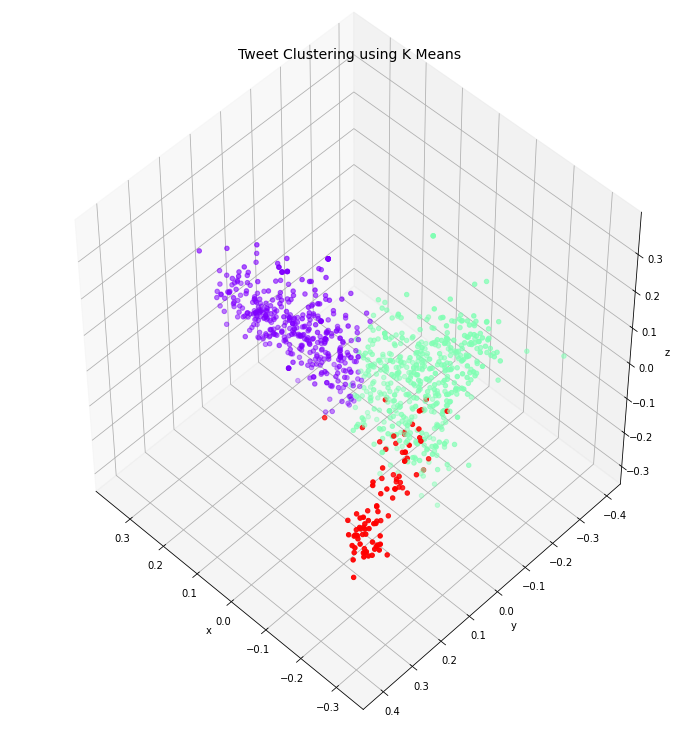

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(data['x'],data['y'],data['z'], c=data['cluster'], cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')
plt.title("Tweet Clustering using K Means", fontsize=14)